In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import scienceplots
plt.style.use('science')
from pylab import xticks,yticks,np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from scipy.stats import gaussian_kde, norm
from sklearn.mixture import GaussianMixture

from utils_f4f import si_format
import json

In [18]:
# Import data 
assay = 'nor_package'
array = 'AA_sequence'

df_all = pd.read_csv('../data/1st_780w_packseq_aa.tsv',delimiter='\t')
df_all = df_all.rename(columns={'aa':'AA_sequence'})
df = df_all[['AA_sequence', 'nor_package']]
df= df.sort_values(by='nor_package')

#Fill in the nan data and replace the inf value
df['nor_package'] = df['nor_package'].fillna(0)  
df['nor_package'] = df['nor_package'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['nor_package','AA_sequence'])

#Stratified sampling
df = df.iloc[::5]
df.shape

(1561098, 2)

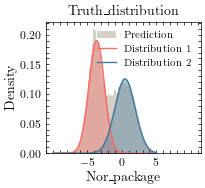

In [3]:
nor_package = df_all[np.isfinite(df_all[assay])][assay]
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 5, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# Plot the normal distribution for each component
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Truth_distribution',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
plt.show()

In [19]:


def onehot_flatten(integer_vec, alphabet):
    num_labels = len(alphabet)
    one_hot = np.zeros((len(integer_vec), num_labels))
    one_hot[np.arange(len(integer_vec)), integer_vec] = 1
    return one_hot.flatten()

def seq_to_onehot(char_sequences, alphabet):
    char_to_int = {c: i for i, c in enumerate(alphabet)}
    integer_encoded = [[char_to_int[char] for char in seq] for seq in char_sequences]
    integer_encoded = pd.DataFrame(integer_encoded)
    
    one_hot_encoded_list = []
    for index, row in integer_encoded.iterrows():
        one_hot_encoded_list.append(onehot_flatten(row, alphabet))
    
    one_hot_encoded = pd.DataFrame(one_hot_encoded_list, dtype='int')
    
    return one_hot_encoded, integer_encoded

# Define alphabet
alphabet = 'ACDEFGHIKLMNPQRSTVWY'
# Apply one-hot encoding
X, integer_encoded = seq_to_onehot(list(df['AA_sequence']), alphabet=alphabet)

In [5]:
X

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156105,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
156106,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
156107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156108,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [5]:
aa_values_list  = X
nor_package_values_list = df['nor_package']



In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Example training data

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(aa_values_list, nor_package_values_list, test_size=0.2, random_state=42)
# Create and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Example sequence to predict
sequence_to_predict = X_test # Replace with your encoded sequence

# Make predictions
predicted_activity = model.predict(sequence_to_predict)
print("Predicted Activity:", predicted_activity)


Predicted Activity: [-0.63183594 -4.44628906 -0.95996094 ... -3.12695312 -1.69238281
 -2.49316406]


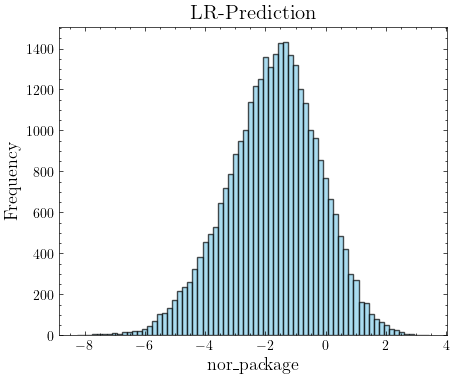

In [7]:
df2 = pd.DataFrame(predicted_activity)
plt.figure(figsize=(5,4),dpi=100)  # 设置图形大小
plt.hist(df2, bins=70, color='skyblue', alpha=0.7, edgecolor='black')
plt.title('LR-Prediction',fontsize=15)
plt.xlabel('nor_package',fontsize=13)
plt.ylabel('Frequency',fontsize=13)
plt.grid(False)

C:\Users\WENJIA\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\WENJIA\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


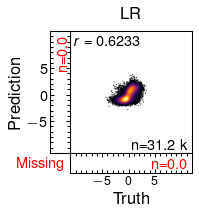

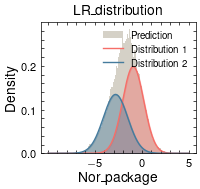

In [8]:
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler

plt.style.use('nature')
x = pd.DataFrame(y_test.values) 
y = pd.DataFrame(predicted_activity)

remove = np.isnan(x) & np.isnan(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isnan(x)) & (~np.isnan(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isnan(x)]
x_missing = x[np.isnan(y)]

df1 = pd.DataFrame(predicted_activity)
df2 = pd.DataFrame(y_test)

random_indices = np.random.choice(len(df1), size=len(y), replace=False)

df1_sampled = df1.iloc[random_indices]
df2_sampled = df2.iloc[random_indices]

# 对数据进行归一化
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
xy = np.vstack([x_scaled, y_scaled])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x_both, y_both, c_both = x_scaled[idx], y_scaled[idx], z[idx]
fig = plt.figure(figsize=(1.4,1.3), dpi=150)
gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.4f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)
plt.title('LR', fontsize=8)
ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5])
ax.text(0.97, 0.97, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=2,fontsize=8)

ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
# fig.savefig('../',dpi=300,bbox_inches='tight')

fig.savefig('aa_nor_package_LR.pdf',dpi=400,bbox_inches='tight')
plt.show()



nor_package = df1
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 5, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# Plot the normal distribution for each component
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('LR_distribution',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
fig.savefig('aa_package_distribution_LR.pdf',dpi=400,bbox_inches='tight')
plt.show()


### 多项式回归

In [10]:
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import PolynomialFeatures, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score
# import numpy as np

# # Assuming X_train and y_train are your training data
# X_train = aa_values_list  # [1,2,3,4,5,6,7]Replace with your encoded sequences
# y_train = nor_package_values_list # [0.776526434]Replace with your corresponding activity values

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

# # Feature scaling
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Linear Regression
# model = LinearRegression()
# model.fit(X_train_scaled, y_train)

# # Polynomial Regression (degree=2, for example)
# poly = PolynomialFeatures(degree=3)
# X_train_poly = poly.fit_transform(X_train_scaled)
# X_test_poly = poly.transform(X_test_scaled)

# poly_model = LinearRegression()
# poly_model.fit(X_train_poly, y_train)

# # Make predictions
# y_pred_linear = model.predict(X_test_scaled)
# y_pred_poly = poly_model.predict(X_test_poly)

# # Evaluate performance
# r2_linear = r2_score(y_test, y_pred_linear)
# r2_poly = r2_score(y_test, y_pred_poly)

# print("R-squared (Linear Regression):", r2_linear)
# print("R-squared (Polynomial Regression):", r2_poly)


In [11]:
# from scipy.stats import gaussian_kde
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from sklearn.preprocessing import StandardScaler
# df1 = pd.DataFrame(y_pred_poly)
# df2 = pd.DataFrame(y_test)

# random_indices = np.random.choice(len(df1), size=10000, replace=False)
# df1_sampled = df1.iloc[random_indices]
# df2_sampled = df2.iloc[random_indices]

# # 对数据进行归一化
# scaler = StandardScaler()
# x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
# y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
# xy = np.vstack([x_scaled, y_scaled])
# z = gaussian_kde(xy)(xy)
# idx = z.argsort()
# x_scaled, y_scaled, z = x_scaled[idx], y_scaled[idx], z[idx]
# plt.style.use('nature')
# fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
# scatter = ax.scatter(x_scaled, y_scaled, marker='o', c=z, edgecolors='none', s=10, cmap='Spectral_r', alpha=0.7)

# ax.set_xlabel('Turth (Normalized)')
# ax.set_ylabel('Predictions (Normalized)')
# ax.set_title('Corralation + Polynomial Regression ')

# correlation = df1.corrwith(df2)
# print("LR结果相关性：", correlation)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
# cbar = fig.colorbar(scatter, cax=cax, label='Frequency')
# ax.text(0.3, 0.1, f'Correlation: {0.275104:.4f}', transform=ax.transAxes, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))

# plt.show()


# plt.style.use('nature')
# data = np.array(df1) 
# data = data.reshape(-1, 1)  # 将数据转换成列向量的形式

# # 使用GaussianMixture拟合数据
# n_components = 2 # 设置混合模型的分量个数
# gmm = GaussianMixture(n_components=n_components)
# gmm.fit(data)

# # 获取每个分量的均值和协方差矩阵
# means = gmm.means_
# covariances = gmm.covariances_

# # 生成拟合后的分布
# x = np.linspace(-7, 5, 100000)
# x = x.reshape(-1, 1)
# y = np.exp(gmm.score_samples(x))

# fig,ax = plt.subplots(figsize=(3,2.4),dpi=300)
# # 绘制原始数据和拟合后的分布
# plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')
# #plt.plot(x, y, '-r', label='GMM fit')


# # 绘制每个分量的正态分布
# for i in range(n_components):
#     component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
#     component /= np.sqrt(2 * np.pi * covariances[i])
#     component *= gmm.weights_[i]
#     if i == 0:
#         ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
#         ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
#     else:
#         ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
#         ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)

# # ax.spines['top'].set_visible(False)
# # ax.spines['right'].set_visible(False)
# # ax.spines['left'].set_visible(False)
# plt.title('Prediction Distribution(KDE) Polynomial Regression',fontsize=7)
# # ax.tick_params(axis='both', which='both', length=0)
# # ax.set_yticks([])
# plt.ylabel('Density')
# plt.xlabel('Nor_package')
# plt.legend()
# plt.show()

#### RidgeCV回归

In [12]:
# from sklearn.linear_model import RidgeCV
# from sklearn.preprocessing import PolynomialFeatures, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score

# # Example training data
# X_train = aa_values_list  # Replace with your encoded sequences
# y_train = nor_package_values_list  # Replace with your corresponding activity values

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# # Standardize the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Create polynomial features
# poly = PolynomialFeatures(degree=4)  # You can adjust the degree
# X_train_poly = poly.fit_transform(X_train_scaled)
# X_test_poly = poly.transform(X_test_scaled)

# # Create and train a Ridge regression model with cross-validated alpha
# model = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=5)  # Adjust alphas and cv as needed
# model.fit(X_train_poly, y_train)

# # Make predictions on the test set
# predicted_activity = model.predict(X_test_poly)

# # Evaluate the model
# mse = mean_squared_error(y_test, predicted_activity)
# r2 = r2_score(y_test, predicted_activity)

# print("Mean Squared Error:", mse)
# print("R-squared:", r2)


In [13]:
# from scipy.stats import gaussian_kde
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from sklearn.preprocessing import StandardScaler
# df1 = pd.DataFrame(predicted_activity)
# df2 = pd.DataFrame(y_test)

# random_indices = np.random.choice(len(df1), size=10000, replace=False)
# df1_sampled = df1.iloc[random_indices]
# df2_sampled = df2.iloc[random_indices]

# # 对数据进行归一化
# scaler = StandardScaler()
# x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
# y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
# xy = np.vstack([x_scaled, y_scaled])
# z = gaussian_kde(xy)(xy)
# idx = z.argsort()
# x_scaled, y_scaled, z = x_scaled[idx], y_scaled[idx], z[idx]
# plt.style.use('nature')
# fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
# scatter = ax.scatter(x_scaled, y_scaled, marker='o', c=z, edgecolors='none', s=10, cmap='Spectral_r', alpha=0.7)

# ax.set_xlabel('Turth (Normalized)')
# ax.set_ylabel('Predictions (Normalized)')
# ax.set_title('Corralation + RidgeCV ')

# correlation = df1.corrwith(df2)
# print("LR结果相关性：", correlation)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
# cbar = fig.colorbar(scatter, cax=cax, label='Frequency')
# ax.text(0.3, 0.7, f'Correlation: { 0.306104:.4f}', transform=ax.transAxes, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))

# plt.show()


# plt.style.use('nature')
# data = np.array(df1) 
# data = data.reshape(-1, 1)  # 将数据转换成列向量的形式

# # 使用GaussianMixture拟合数据
# n_components = 2 # 设置混合模型的分量个数
# gmm = GaussianMixture(n_components=n_components)
# gmm.fit(data)

# # 获取每个分量的均值和协方差矩阵
# means = gmm.means_
# covariances = gmm.covariances_

# # 生成拟合后的分布
# x = np.linspace(-7, 5, 100000)
# x = x.reshape(-1, 1)
# y = np.exp(gmm.score_samples(x))

# fig,ax = plt.subplots(figsize=(3,2.4),dpi=300)
# # 绘制原始数据和拟合后的分布
# plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')
# #plt.plot(x, y, '-r', label='GMM fit')


# # 绘制每个分量的正态分布
# for i in range(n_components):
#     component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
#     component /= np.sqrt(2 * np.pi * covariances[i])
#     component *= gmm.weights_[i]
#     if i == 0:
#         ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
#         ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
#     else:
#         ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
#         ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)

# # ax.spines['top'].set_visible(False)
# # ax.spines['right'].set_visible(False)
# # ax.spines['left'].set_visible(False)
# plt.title('Prediction Distribution(KDE) RidgeCV Regression',fontsize=7)
# # ax.tick_params(axis='both', which='both', length=0)
# # ax.set_yticks([])
# plt.ylabel('Density')
# plt.xlabel('Nor_package')
# plt.legend()
# plt.show()

#### Lasso

In [14]:
# from sklearn.linear_model import  LassoCV
# from sklearn.preprocessing import PolynomialFeatures, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score

# # Example training data
# X_train = aa_values_list  # Replace with your encoded sequences
# y_train = nor_package_values_list  # Replace with your corresponding activity values

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# # Standardize the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Create polynomial features
# poly = PolynomialFeatures(degree=4)  # You can adjust the degree
# X_train_poly = poly.fit_transform(X_train_scaled)
# X_test_poly = poly.transform(X_test_scaled)

# # Create and train a Ridge regression model with cross-validated alpha
# model = LassoCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=5)  # Adjust alphas and cv as needed
# model.fit(X_train_poly, y_train)

# # Make predictions on the test set
# predicted_activity = model.predict(X_test_poly)

# # Evaluate the model
# mse = mean_squared_error(y_test, predicted_activity)
# r2 = r2_score(y_test, predicted_activity)

# print("Mean Squared Error:", mse)
# print("R-squared:", r2)


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Example training data
X_train = aa_values_list  # Replace with your encoded sequences
y_train = nor_package_values_list  # Replace with your corresponding activity values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create and train a Random Forest regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust parameters as needed
model.fit(X_train, y_train)

# Make predictions on the test set
predicted_activity = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predicted_activity)
r2 = r2_score(y_test, predicted_activity)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


x = pd.DataFrame(y_test.values) 
y = pd.DataFrame(predicted_activity)

remove = np.isnan(x) & np.isnan(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isnan(x)) & (~np.isnan(y))
x_both = x[keep]
y_both = y[keep]


x_both.corrwith(y_both)


Mean Squared Error: 3.5846715573251644
R-squared: 0.3873452603279768


0    0.622758
dtype: float64

0    0.625503
dtype: float64

0    0.622758
dtype: float64

In [9]:
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler

plt.style.use('nature')
x = pd.DataFrame(y_test.values) 
y = pd.DataFrame(predicted_activity)

remove = np.isnan(x) & np.isnan(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isnan(x)) & (~np.isnan(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isnan(x)]
x_missing = x[np.isnan(y)]

df1 = pd.DataFrame(predicted_activity)
df2 = pd.DataFrame(y_test)

random_indices = np.random.choice(len(df1), size=len(y), replace=False)

df1_sampled = df1.iloc[random_indices]
df2_sampled = df2.iloc[random_indices]

# 对数据进行归一化
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
xy = np.vstack([x_scaled, y_scaled])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x_both, y_both, c_both = x_scaled[idx], y_scaled[idx], z[idx]
fig = plt.figure(figsize=(1.4,1.3), dpi=150)
gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
plt.title('RandomForest',fontsize=8)
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.4f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5])
ax.text(0.97, 0.97, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
# fig.savefig('../',dpi=300,bbox_inches='tight')
# fig.savefig('aa_nor_package_correlation_RandomForest.pdf',dpi=400,bbox_inches='tight')
# plt.show()

nor_package = df1
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 5, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# Plot the normal distribution for each component
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


# plt.title('Distribution-RandomForest',fontsize=10)
# ax.tick_params(axis='both', which='both', length=2,labelsize=8)
# ax.set_xticks([-5, 0, 5]); 
# # ax.set_yticks([])
# plt.ylabel('Density',labelpad=2,fontsize=10)
# plt.xlabel('Nor_package',labelpad=2,fontsize=10)
# plt.legend(fontsize=7,frameon=False,loc='best')
# fig.savefig('aa_package_distribution_RandomForest.pdf',dpi=400,bbox_inches='tight')
# plt.show()



#### 提升结果

In [17]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score

# # Example training data
# X_train = aa_values_list  # Replace with your encoded sequences
# y_train = nor_package_values_list  # Replace with your corresponding activity values

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# # Create and train a Gradient Boosting regression model
# model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.2, max_depth=5, random_state=42)  
# # You can adjust parameters such as n_estimators, learning_rate, and max_depth

# model.fit(X_train, y_train)

# # Make predictions on the test set
# predicted_activity = model.predict(X_test)

# # Evaluate the model
# mse = mean_squared_error(y_test, predicted_activity)
# r2 = r2_score(y_test, predicted_activity)

# print("Mean Squared Error:", mse)
# print("R-squared:", r2)


Mean Squared Error: 3.5428584366800004
R-squared: 0.39449152355853423


C:\Users\WENJIA\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\WENJIA\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


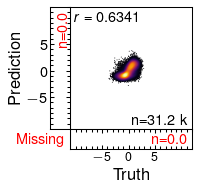

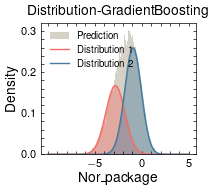

In [18]:
# from scipy.stats import gaussian_kde
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from sklearn.preprocessing import StandardScaler

# plt.style.use('nature')
# x = pd.DataFrame(y_test.values) 
# y = pd.DataFrame(predicted_activity)

# remove = np.isnan(x) & np.isnan(y)
# x = x[~remove]
# y = y[~remove]

# keep = (~np.isnan(x)) & (~np.isnan(y))
# x_both = x[keep]
# y_both = y[keep]

# y_missing = y[np.isnan(x)]
# x_missing = x[np.isnan(y)]

# df1 = pd.DataFrame(predicted_activity)
# df2 = pd.DataFrame(y_test)

# random_indices = np.random.choice(len(df1), size=len(y), replace=False)

# df1_sampled = df1.iloc[random_indices]
# df2_sampled = df2.iloc[random_indices]

# # 对数据进行归一化
# scaler = StandardScaler()
# x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
# y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
# xy = np.vstack([x_scaled, y_scaled])
# z = gaussian_kde(xy)(xy)

# idx = z.argsort()
# x_both, y_both, c_both = x_scaled[idx], y_scaled[idx], z[idx]
# fig = plt.figure(figsize=(1.4,1.3), dpi=150)
# gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
#                       width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
# ax = fig.add_subplot(gs[0, 1])
# ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
# ax.set_xticks([]); ax.set_yticks([])
# xlim = [-11, 12]
# bins = np.linspace(*xlim, 25)
# ax.set_xlim(xlim); ax.set_ylim(xlim)
# ax.text(0.03, 0.97, r'$r$ = {:.4f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
#        transform=ax.transAxes, ha='left', va='top', fontsize=7)

# ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
#         transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# # Left Marginal
# ax = fig.add_subplot(gs[0, 0])
# ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
# ax.set_ylim(xlim)
# ax.set_xticks([]); ax.set_yticks([-5, 0, 5])
# ax.text(0.97, 0.97, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
#         transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
# ax.set_ylabel('Prediction', labelpad=2,fontsize=8)
# ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# # Bottom Marginal
# ax = fig.add_subplot(gs[1, 1])
# ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
# ax.set_xlim(xlim)
# ax.set_xticks([-5, 0, 5]); ax.set_yticks([])
# ax.text(0.97, 0.8, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
#         transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
# ax.set_xlabel('Truth', labelpad=2,fontsize=8)
# ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# # Missing label (not detected in either)
# ax = fig.add_subplot(gs[1, 0])
# for spine in ['bottom', 'left']:
#     ax.spines[spine].set_visible(False)
# ax.set_xticks([]); ax.set_yticks([])

# ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
# # fig.savefig('../',dpi=300,bbox_inches='tight')


# nor_package = df1
# data = np.array(nor_package) 
# data = data.reshape(-1, 1)  # Convert the data into a column vector

# # Fit the data using GaussianMixture
# n_components = 2 # Set the number of components for the hybrid model
# gmm = GaussianMixture(n_components=n_components)
# gmm.fit(data)

# # Get the mean and covariance matrix for each component
# means = gmm.means_
# covariances = gmm.covariances_

# # Generate the fitted distribution
# x = np.linspace(-10, 5, 10000)
# x = x.reshape(-1, 1)
# y = np.exp(gmm.score_samples(x))

# fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# # Plot the raw data and the distribution after fitting
# plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# # Plot the normal distribution for each component
# for i in range(n_components):
#     component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
#     component /= np.sqrt(2 * np.pi * covariances[i])
#     component *= gmm.weights_[i]
#     if i == 0:
#         ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
#         ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
#     else:
#         ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
#         ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


# plt.title('Distribution-GradientBoosting',fontsize=10)
# ax.tick_params(axis='both', which='both', length=2,labelsize=8)
# ax.set_xticks([-5, 0, 5]); 
# # ax.set_yticks([])
# plt.ylabel('Density',labelpad=2,fontsize=10)
# plt.xlabel('Nor_package',labelpad=2,fontsize=10)
# plt.legend(fontsize=7,frameon=False,loc='best')
# plt.show()


修改提升

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Example training data
X_train = aa_values_list  # Replace with your encoded sequences
y_train = nor_package_values_list  # Replace with your corresponding activity values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create and train a Gradient Boosting regression model
model = GradientBoostingRegressor(n_estimators=400, learning_rate=0.2, max_depth=5, random_state=42)  
# You can adjust parameters such as n_estimators, learning_rate, and max_depth

model.fit(X_train, y_train)

# Make predictions on the test set
predicted_activity = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predicted_activity)
r2 = r2_score(y_test, predicted_activity)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

x = pd.DataFrame(y_test.values) 
y = pd.DataFrame(predicted_activity)

remove = np.isnan(x) & np.isnan(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isnan(x)) & (~np.isnan(y))
x_both = x[keep]
y_both = y[keep]


x_both.corrwith(y_both)

Mean Squared Error: 3.3725057907756897
R-squared: 0.42360642411774285


0    0.650882
dtype: float64

C:\Users\WENJIA\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\WENJIA\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


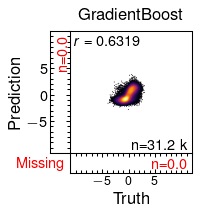

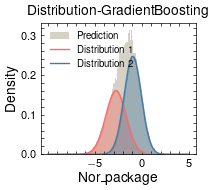

In [12]:
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler

plt.style.use('nature')
x = pd.DataFrame(y_test.values) 
y = pd.DataFrame(predicted_activity)

remove = np.isnan(x) & np.isnan(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isnan(x)) & (~np.isnan(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isnan(x)]
x_missing = x[np.isnan(y)]

df1 = pd.DataFrame(predicted_activity)
df2 = pd.DataFrame(y_test)

random_indices = np.random.choice(len(df1), size=len(y), replace=False)

df1_sampled = df1.iloc[random_indices]
df2_sampled = df2.iloc[random_indices]

# 对数据进行归一化
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
xy = np.vstack([x_scaled, y_scaled])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x_both, y_both, c_both = x_scaled[idx], y_scaled[idx], z[idx]
fig = plt.figure(figsize=(1.4,1.3), dpi=150)
gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
plt.title('GradientBoost',fontsize=8)
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.4f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5])
ax.text(0.97, 0.97, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
# fig.savefig('../',dpi=300,bbox_inches='tight')
fig.savefig('aa_nor_package_correlation_GradientBoost.pdf',dpi=400,bbox_inches='tight')
plt.show()


nor_package = df1
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 5, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# Plot the normal distribution for each component
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Distribution-GradientBoosting',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
fig.savefig('aa_nor_package_distribution_GradientBoost.pdf',dpi=400,bbox_inches='tight')
plt.show()



In [106]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Example training data
X_train, X_test, y_train, y_test = train_test_split(aa_values_list, nor_package_values_list, test_size=0.2, random_state=42)
arr = []
n_arr = [50,100,150,200,250,300,350,400,450,500]
for num in n_arr:
    # Create and train an XGBoost regression model
    model = XGBRegressor(n_estimators=num, learning_rate=0.2, max_depth=9, subsample=0.8, colsample_bytree=0.8, gamma=1, random_state=42)

    model.fit(X_train, y_train)

    # Make predictions on the test set
    predicted_activity = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predicted_activity)
    r2 = r2_score(y_test, predicted_activity)

    print("Mean Squared Error:", mse)
    print("R-squared:", r2)
    #300  0.38  
    # 0.2 0.39
    # 400 0.40  500  +0.003   1000 +0.011  0.418

    x = pd.DataFrame(y_test.values) 
    y = pd.DataFrame(predicted_activity)

    remove = np.isnan(x) & np.isnan(y)
    x = x[~remove]
    y = y[~remove]

    keep = (~np.isnan(x)) & (~np.isnan(y))
    x_both = x[keep]
    y_both = y[keep]


    corr = x_both.corrwith(y_both)
    arr.append([mse,r2,corr])


    with open('xgboost_9.txt', 'w') as f:
        # Write each element of arr to the file, converting it to a string first
        for item in arr:
            line = '\t'.join(map(str, item))  # Convert elements to string and separate by tab
            f.write(line + '\n')  # Write line and add newline character at the end



Mean Squared Error: 3.512928053609436
R-squared: 0.3996069130036033
Mean Squared Error: 3.4143708275270543
R-squared: 0.41645128792685415
Mean Squared Error: 3.3972199529570166
R-squared: 0.4193825368367806
Mean Squared Error: 3.4153581370982193
R-squared: 0.41628254725462666
Mean Squared Error: 3.440898016689866
R-squared: 0.4119175369511022
Mean Squared Error: 3.4694899350233546
R-squared: 0.4070309039630585
Mean Squared Error: 3.5022854407757986
R-squared: 0.4014258375803049
Mean Squared Error: 3.53270306132874
R-squared: 0.39622717457777035
Mean Squared Error: 3.5545334497755516
R-squared: 0.39249615187821785
Mean Squared Error: 3.584514549056623
R-squared: 0.38737209454649624


C:\Users\WENJIA\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\WENJIA\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


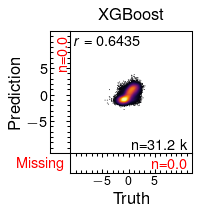

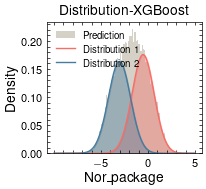

In [14]:
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler

plt.style.use('nature')
x = pd.DataFrame(y_test.values) 
y = pd.DataFrame(predicted_activity)

remove = np.isnan(x) & np.isnan(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isnan(x)) & (~np.isnan(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isnan(x)]
x_missing = x[np.isnan(y)]

df1 = pd.DataFrame(predicted_activity)
df2 = pd.DataFrame(y_test)

random_indices = np.random.choice(len(df1), size=len(y), replace=False)

df1_sampled = df1.iloc[random_indices]
df2_sampled = df2.iloc[random_indices]

# 对数据进行归一化
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
xy = np.vstack([x_scaled, y_scaled])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x_both, y_both, c_both = x_scaled[idx], y_scaled[idx], z[idx]
fig = plt.figure(figsize=(1.4,1.3), dpi=150)
gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
plt.title('XGBoost',fontsize=8)
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.4f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5])
ax.text(0.97, 0.97, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
# fig.savefig('../',dpi=300,bbox_inches='tight')
fig.savefig('aa_nor_package_correlation_XGBoost.pdf',dpi=400,bbox_inches='tight')
plt.show()




nor_package = df1
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 5, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# Plot the normal distribution for each component
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Distribution-XGBoost',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
fig.savefig('aa_nor_package_distribution_XGBoost.pdf',dpi=400,bbox_inches='tight')
plt.show()


继续提升

In [23]:
# from xgboost import XGBRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score
# r2 = r2_score(y_test, predicted_activity)

# # Example training data
# X_train, X_test, y_train, y_test = train_test_split(aa_values_list, nor_package_values_list, test_size=0.2, random_state=42)

# # Create and train an XGBoost regression model
# model = XGBRegressor(n_estimators=100, learning_rate=0.3, max_depth=7, subsample=0.8, colsample_bytree=0.8, gamma=1, random_state=42)

# model.fit(X_train, y_train)

# # Make predictions on the test set
# predicted_activity = model.predict(X_test)

# # Evaluate the model
# from sklearn.metrics import mean_squared_error, r2_score
# mse = mean_squared_error(y_test, predicted_activity)
# r2 = r2_score(y_test, predicted_activity)

# print("Mean Squared Error:", mse)
# print("R-squared:", r2)
# #300  0.38  
# # 0.2 0.39
# # 400 0.40  500  +0.003   1000 +0.011  0.418


Mean Squared Error: 3.43949552437823
R-squared: 0.4121572363345287


C:\Users\WENJIA\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\WENJIA\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


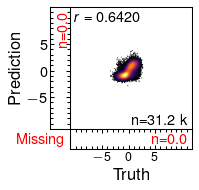

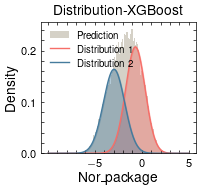

In [24]:
# from scipy.stats import gaussian_kde
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from sklearn.preprocessing import StandardScaler

# plt.style.use('nature')
# x = pd.DataFrame(y_test.values) 
# y = pd.DataFrame(predicted_activity)

# remove = np.isnan(x) & np.isnan(y)
# x = x[~remove]
# y = y[~remove]

# keep = (~np.isnan(x)) & (~np.isnan(y))
# x_both = x[keep]
# y_both = y[keep]

# y_missing = y[np.isnan(x)]
# x_missing = x[np.isnan(y)]

# df1 = pd.DataFrame(predicted_activity)
# df2 = pd.DataFrame(y_test)

# random_indices = np.random.choice(len(df1), size=len(y), replace=False)

# df1_sampled = df1.iloc[random_indices]
# df2_sampled = df2.iloc[random_indices]

# # 对数据进行归一化
# scaler = StandardScaler()
# x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
# y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
# xy = np.vstack([x_scaled, y_scaled])
# z = gaussian_kde(xy)(xy)

# idx = z.argsort()
# x_both, y_both, c_both = x_scaled[idx], y_scaled[idx], z[idx]
# fig = plt.figure(figsize=(1.4,1.3), dpi=150)
# gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
#                       width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
# ax = fig.add_subplot(gs[0, 1])
# ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
# ax.set_xticks([]); ax.set_yticks([])
# xlim = [-11, 12]
# bins = np.linspace(*xlim, 25)
# ax.set_xlim(xlim); ax.set_ylim(xlim)
# ax.text(0.03, 0.97, r'$r$ = {:.4f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
#        transform=ax.transAxes, ha='left', va='top', fontsize=7)

# ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
#         transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# # Left Marginal
# ax = fig.add_subplot(gs[0, 0])
# ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
# ax.set_ylim(xlim)
# ax.set_xticks([]); ax.set_yticks([-5, 0, 5])
# ax.text(0.97, 0.97, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
#         transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
# ax.set_ylabel('Prediction', labelpad=2,fontsize=8)
# ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# # Bottom Marginal
# ax = fig.add_subplot(gs[1, 1])
# ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
# ax.set_xlim(xlim)
# ax.set_xticks([-5, 0, 5]); ax.set_yticks([])
# ax.text(0.97, 0.8, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
#         transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
# ax.set_xlabel('Truth', labelpad=2,fontsize=8)
# ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# # Missing label (not detected in either)
# ax = fig.add_subplot(gs[1, 0])
# for spine in ['bottom', 'left']:
#     ax.spines[spine].set_visible(False)
# ax.set_xticks([]); ax.set_yticks([])

# ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
# # fig.savefig('../',dpi=300,bbox_inches='tight')


# nor_package = df1
# data = np.array(nor_package) 
# data = data.reshape(-1, 1)  # Convert the data into a column vector

# # Fit the data using GaussianMixture
# n_components = 2 # Set the number of components for the hybrid model
# gmm = GaussianMixture(n_components=n_components)
# gmm.fit(data)

# # Get the mean and covariance matrix for each component
# means = gmm.means_
# covariances = gmm.covariances_

# # Generate the fitted distribution
# x = np.linspace(-10, 5, 10000)
# x = x.reshape(-1, 1)
# y = np.exp(gmm.score_samples(x))

# fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# # Plot the raw data and the distribution after fitting
# plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# # Plot the normal distribution for each component
# for i in range(n_components):
#     component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
#     component /= np.sqrt(2 * np.pi * covariances[i])
#     component *= gmm.weights_[i]
#     if i == 0:
#         ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
#         ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
#     else:
#         ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
#         ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


# plt.title('Distribution-XGBoost',fontsize=10)
# ax.tick_params(axis='both', which='both', length=2,labelsize=8)
# ax.set_xticks([-5, 0, 5]); 
# # ax.set_yticks([])
# plt.ylabel('Density',labelpad=2,fontsize=10)
# plt.xlabel('Nor_package',labelpad=2,fontsize=10)
# plt.legend(fontsize=7,frameon=False,loc='best')
# plt.show()


In [105]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Example training data
X_train, X_test, y_train, y_test = train_test_split(aa_values_list, nor_package_values_list, test_size=0.2, random_state=42)
arr = []
n_arr = [50,100,150,200,250,300,350,400,450,500]
for num in n_arr:  
    # Create and train an XGBoost regression model
    model =CatBoostRegressor(n_estimators=num, learning_rate=0.4, depth=9, random_seed=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predicted_activity = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predicted_activity)
    r2 = r2_score(y_test, predicted_activity)

    print("Mean Squared Error:", mse)
    print("R-squared:", r2)


    x = pd.DataFrame(y_test.values) 
    y = pd.DataFrame(predicted_activity)

    remove = np.isnan(x) & np.isnan(y)
    x = x[~remove]
    y = y[~remove]

    keep = (~np.isnan(x)) & (~np.isnan(y))
    x_both = x[keep]
    y_both = y[keep]


    corr = x_both.corrwith(y_both)
    arr.append([mse,r2,corr])


    with open('catboost_9.txt', 'w') as f:
        # Write each element of arr to the file, converting it to a string first
        for item in arr:
            line = '\t'.join(map(str, item))  # Convert elements to string and separate by tab
            f.write(line + '\n')  # Write line and add newline character at the end


0:	learn: 2.3223437	total: 12ms	remaining: 588ms
1:	learn: 2.2661775	total: 46.6ms	remaining: 1.12s
2:	learn: 2.2167403	total: 60ms	remaining: 940ms
3:	learn: 2.1764659	total: 72ms	remaining: 828ms
4:	learn: 2.1397530	total: 85.1ms	remaining: 766ms
5:	learn: 2.1087961	total: 96.7ms	remaining: 709ms
6:	learn: 2.0832696	total: 109ms	remaining: 670ms
7:	learn: 2.0611684	total: 123ms	remaining: 646ms
8:	learn: 2.0422679	total: 137ms	remaining: 625ms
9:	learn: 2.0238549	total: 150ms	remaining: 602ms
10:	learn: 2.0093349	total: 166ms	remaining: 589ms
11:	learn: 1.9959998	total: 180ms	remaining: 572ms
12:	learn: 1.9840971	total: 193ms	remaining: 549ms
13:	learn: 1.9742803	total: 213ms	remaining: 548ms
14:	learn: 1.9653935	total: 229ms	remaining: 533ms
15:	learn: 1.9572560	total: 243ms	remaining: 515ms
16:	learn: 1.9486301	total: 255ms	remaining: 495ms
17:	learn: 1.9415307	total: 268ms	remaining: 477ms
18:	learn: 1.9349514	total: 279ms	remaining: 456ms
19:	learn: 1.9297067	total: 292ms	remaini

C:\Users\WENJIA\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\WENJIA\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


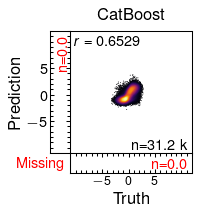

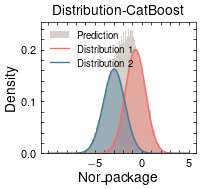

In [17]:
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler

plt.style.use('nature')
x = pd.DataFrame(y_test.values) 
y = pd.DataFrame(predicted_activity)

remove = np.isnan(x) & np.isnan(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isnan(x)) & (~np.isnan(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isnan(x)]
x_missing = x[np.isnan(y)]

df1 = pd.DataFrame(predicted_activity)
df2 = pd.DataFrame(y_test)

random_indices = np.random.choice(len(df1), size=len(y), replace=False)

df1_sampled = df1.iloc[random_indices]
df2_sampled = df2.iloc[random_indices]

# 对数据进行归一化
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
xy = np.vstack([x_scaled, y_scaled])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x_both, y_both, c_both = x_scaled[idx], y_scaled[idx], z[idx]
fig = plt.figure(figsize=(1.4,1.3), dpi=150)
gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
plt.title('CatBoost',fontsize=8)
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.4f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5])
ax.text(0.97, 0.97, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
# fig.savefig('../',dpi=300,bbox_inches='tight')
fig.savefig('aa_nor_package_correlation_CatBoost.pdf',dpi=400,bbox_inches='tight')
plt.show()


nor_package = df1
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 5, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# Plot the normal distribution for each component
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Distribution-CatBoost',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-5, 0, 5]); 
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
fig.savefig('aa_nor_package_distribution_CatBoost.pdf',dpi=400,bbox_inches='tight')
plt.show()



In [121]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Example training data
X_train, X_test, y_train, y_test = train_test_split(aa_values_list, nor_package_values_list, test_size=0.2, random_state=42)
arr = []
n_arr = [50,100,150,200,250,300,350,400,450,500]
for num in n_arr:  
    # Create and train an XGBoost regression model
    model = LGBMRegressor(iterations=9000, n_estimators=num, learning_rate=0.4, max_depth=7, random_seed=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predicted_activity = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predicted_activity)
    r2 = r2_score(y_test, predicted_activity)

    print("Mean Squared Error:", mse)
    print("R-squared:", r2)


    x = pd.DataFrame(y_test.values) 
    y = pd.DataFrame(predicted_activity)

    remove = np.isnan(x) & np.isnan(y)
    x = x[~remove]
    y = y[~remove]

    keep = (~np.isnan(x)) & (~np.isnan(y))
    x_both = x[keep]
    y_both = y[keep]
    corr = x_both.corrwith(y_both)

    arr.append([mse,r2,corr])


    with open('LGBMR_7.txt', 'w') as f:
        # Write each element of arr to the file, converting it to a string first
        for item in arr:
            line = '\t'.join(map(str, item))  # Convert elements to string and separate by tab
            f.write(line + '\n')  # Write line and add newline character at the end


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 124888, number of used features: 140
[LightGBM] [Info] Start training from score -1.756799
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Mean Squared Error: 3.4541463439354203
R-squared:

C:\Users\WENJIA\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\WENJIA\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


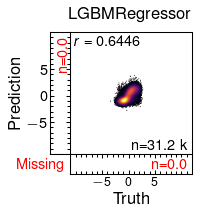

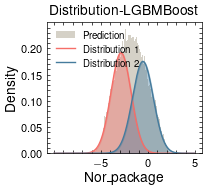

In [19]:
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler

plt.style.use('nature')
x = pd.DataFrame(y_test.values) 
y = pd.DataFrame(predicted_activity)

remove = np.isnan(x) & np.isnan(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isnan(x)) & (~np.isnan(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isnan(x)]
x_missing = x[np.isnan(y)]

df1 = pd.DataFrame(predicted_activity)
df2 = pd.DataFrame(y_test)

random_indices = np.random.choice(len(df1), size=len(y), replace=False)

df1_sampled = df1.iloc[random_indices]
df2_sampled = df2.iloc[random_indices]

# 对数据进行归一化
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
xy = np.vstack([x_scaled, y_scaled])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x_both, y_both, c_both = x_scaled[idx], y_scaled[idx], z[idx]
fig = plt.figure(figsize=(1.4,1.3), dpi=150)
gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
plt.title('LGBMRegressor',fontsize=8)
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.4f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5])
ax.text(0.97, 0.97, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
# fig.savefig('../',dpi=300,bbox_inches='tight')
fig.savefig('aa_nor_package_correlation_LBGM.pdf',dpi=400,bbox_inches='tight')
plt.show()

nor_package = df1
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 5, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# Plot the normal distribution for each component
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Distribution-LGBMBoost',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-5, 0, 5]); 
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
fig.savefig('aa_nor_package_distribution_LBGM.pdf',dpi=400,bbox_inches='tight')
plt.show()


In [29]:
# import numpy as np
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, r2_score

# # Assume X_train and y_train are your training data
# # X_train should be a 2D array with shape (samples, features)
# # y_train should be a 1D array with shape (samples,)

# # Example training data
# X_train = np.array(aa_values_list)
# y_train = np.array(nor_package_values_list)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# # Standardize the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Build the neural network model
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(1, activation='linear')
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# # Make predictions on the test set
# predicted_activity = model.predict(X_test_scaled).flatten()

# # Evaluate the model
# mse = mean_squared_error(y_test, predicted_activity)
# r2 = r2_score(y_test, predicted_activity)

# print("Mean Squared Error:", mse)
# print("R-squared:", r2)


Epoch 1/50
3123/3123 [==============================] - 3s 851us/step - loss: 3.5511 - val_loss: 3.2351
Epoch 2/50
3123/3123 [==============================] - 3s 834us/step - loss: 3.0406 - val_loss: 3.1041
Epoch 3/50
3123/3123 [==============================] - 3s 863us/step - loss: 2.9309 - val_loss: 3.1383
Epoch 4/50
3123/3123 [==============================] - 3s 848us/step - loss: 2.8658 - val_loss: 3.0700
Epoch 5/50
3123/3123 [==============================] - 3s 832us/step - loss: 2.8217 - val_loss: 3.0992
Epoch 6/50
3123/3123 [==============================] - 3s 986us/step - loss: 2.7837 - val_loss: 3.0802
Epoch 7/50
3123/3123 [==============================] - 3s 926us/step - loss: 2.7513 - val_loss: 3.0998
Epoch 8/50
3123/3123 [==============================] - 3s 864us/step - loss: 2.7185 - val_loss: 3.1127
Epoch 9/50
3123/3123 [==============================] - 3s 835us/step - loss: 2.6928 - val_loss: 3.2100
Epoch 10/50
3123/3123 [==============================] - 3s 853u

In [2]:
# 打开JSON文件
plt.style.use('nature')
filename = '100wdata-truth.json'
with open(filename, 'r') as json_file:
    # 使用json.load()方法加载JSON数据
    result_truth = json.load(json_file)
#Type(result) = list

df1 = pd.DataFrame(result_truth)
plt.style.use('nature')
filename = '100w-result-truth_prediction.json'
with open(filename, 'r') as json_file:
    # 使用json.load()方法加载JSON数据
    result_uniform = json.load(json_file)

df2 = pd.DataFrame(result_uniform)
# plt.figure(figsize=(4, 4),dpi=100)  # 设置图形大小
# 绘制直方图
# plt.hist(df2['nor_package'], bins=100, color='skyblue', alpha=0.7, edgecolor='black')

x = df1['nor_package']
y = df2['nor_package']

d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


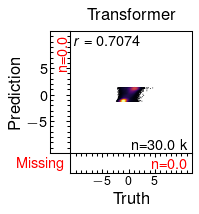

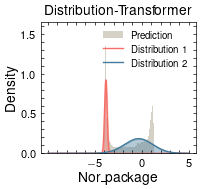

In [3]:
remove = np.isnan(x) & np.isnan(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isnan(x)) & (~np.isnan(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isnan(x)]
x_missing = x[np.isnan(y)]

df1 = x
df2 = y

random_indices = np.random.choice(len(df1), size=30000, replace=False)

df1_sampled = df1.iloc[random_indices]
df2_sampled = df2.iloc[random_indices]

# 对数据进行归一化
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
xy = np.vstack([x_scaled, y_scaled])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x_both, y_both, c_both = x_scaled[idx], y_scaled[idx], z[idx]
fig = plt.figure(figsize=(1.4,1.3), dpi=150)
gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
plt.title('Transformer',fontsize=8)
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.4f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5])
ax.text(0.97, 0.97, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
# fig.savefig('../',dpi=300,bbox_inches='tight')
fig.savefig('aa_nor_package_correlation_Transformer.pdf',dpi=400,bbox_inches='tight')
plt.show()

nor_package = df2
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 5, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# Plot the normal distribution for each component
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Distribution-Transformer',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-5, 0, 5]); 
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
fig.savefig('aa_nor_package_distribution_Transformer.pdf',dpi=400,bbox_inches='tight')
plt.show()

LR结果相关性： 0    0.659256
dtype: float64


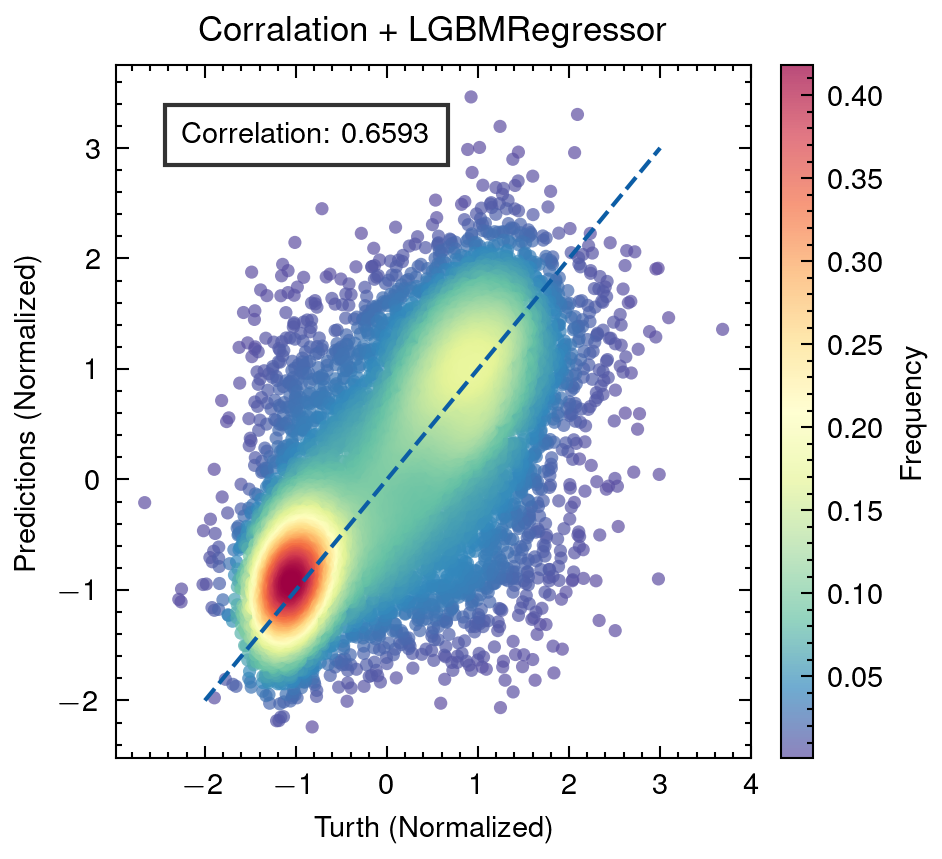

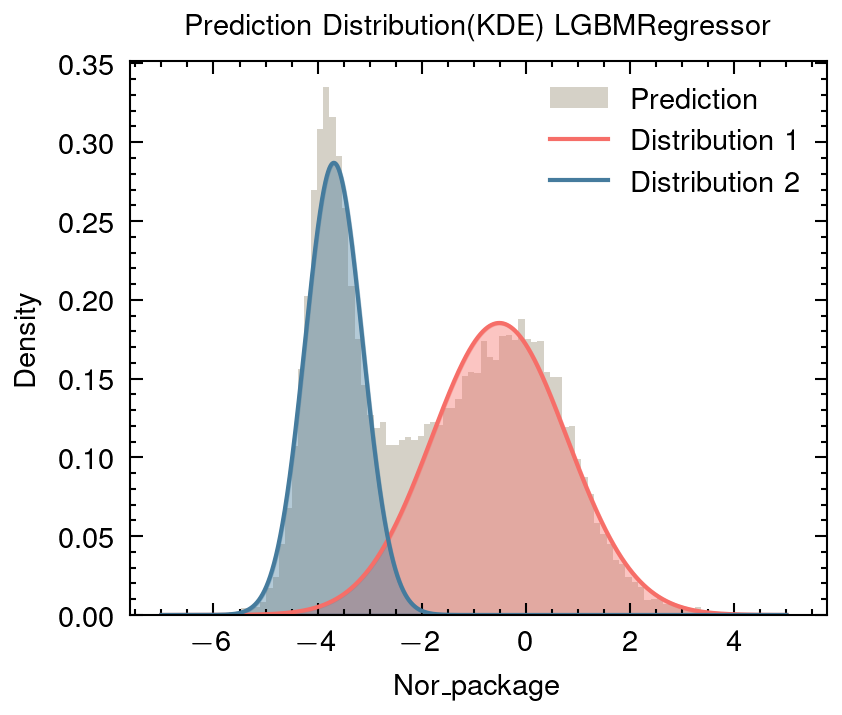

In [30]:

# df1 = pd.DataFrame(predicted_activity)
# df2 = pd.DataFrame(y_test)

# random_indices = np.random.choice(len(df1), size=10000, replace=False)
# df1_sampled = df1.iloc[random_indices]
# df2_sampled = df2.iloc[random_indices]

# # 对数据进行归一化
# scaler = StandardScaler()
# x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
# y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
# xy = np.vstack([x_scaled, y_scaled])
# z = gaussian_kde(xy)(xy)
# idx = z.argsort()
# x_scaled, y_scaled, z = x_scaled[idx], y_scaled[idx], z[idx]
# plt.style.use('nature')
# fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
# scatter = ax.scatter(x_scaled, y_scaled, marker='o', c=z, edgecolors='none', s=10, cmap='Spectral_r', alpha=0.7)

# ax.set_xlabel('Turth (Normalized)')
# ax.set_ylabel('Predictions (Normalized)')
# ax.set_title('Corralation + LGBMRegressor')

# correlation = df1.corrwith(df2)
# print("LR结果相关性：", correlation)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
# cbar = fig.colorbar(scatter, cax=cax, label='Frequency')
# ax.text(0.3, 0.9, f'Correlation: {correlation.values[0]:.4f}', transform=ax.transAxes, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))
# ax.plot([-2, 3], [-2, 3], ls="--", )

# plt.show()


# plt.style.use('nature')
# data = np.array(df1) 
# data = data.reshape(-1, 1)  # 将数据转换成列向量的形式

# # 使用GaussianMixture拟合数据
# n_components = 2 # 设置混合模型的分量个数
# gmm = GaussianMixture(n_components=n_components)
# gmm.fit(data)

# # 获取每个分量的均值和协方差矩阵
# means = gmm.means_
# covariances = gmm.covariances_

# # 生成拟合后的分布
# x = np.linspace(-7, 5, 100000)
# x = x.reshape(-1, 1)
# y = np.exp(gmm.score_samples(x))

# fig,ax = plt.subplots(figsize=(3,2.4),dpi=300)
# # 绘制原始数据和拟合后的分布
# plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')
# #plt.plot(x, y, '-r', label='GMM fit')


# # 绘制每个分量的正态分布
# for i in range(n_components):
#     component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
#     component /= np.sqrt(2 * np.pi * covariances[i])
#     component *= gmm.weights_[i]
#     if i == 0:
#         ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
#         ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
#     else:
#         ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
#         ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)

# # ax.spines['top'].set_visible(False)
# # ax.spines['right'].set_visible(False)
# # ax.spines['left'].set_visible(False)
# plt.title('Prediction Distribution(KDE)  LGBMRegressor',fontsize=7)
# # ax.tick_params(axis='both', which='both', length=0)
# # ax.set_yticks([])
# plt.ylabel('Density')
# plt.xlabel('Nor_package')
# plt.legend()
# plt.show()

In [31]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Example training data
X_train = np.array(aa_values_list)
y_train = np.array(nor_package_values_list)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),  # Batch Normalization layer
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),  # Batch Normalization layer
    tf.keras.layers.Dense(1, activation='relu')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error')

# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train_scaled, y_train, epochs=20, batch_size=16, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Make predictions on the test set
predicted_activity = model.predict(X_test_scaled).flatten()

# Evaluate the model
mse = mean_squared_error(y_test, predicted_activity)
r2 = r2_score(y_test, predicted_activity)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Epoch 1/20
6245/6245 [==============================] - 8s 1ms/step - loss: 9.0441 - val_loss: 9.0090
Epoch 2/20
6245/6245 [==============================] - 7s 1ms/step - loss: 8.9906 - val_loss: 9.0102
Epoch 3/20
6245/6245 [==============================] - 7s 1ms/step - loss: 8.9902 - val_loss: 9.0090
Epoch 4/20
6245/6245 [==============================] - 6s 1ms/step - loss: 8.9901 - val_loss: 9.0091
Epoch 5/20
6245/6245 [==============================] - 7s 1ms/step - loss: 8.9901 - val_loss: 9.0091
Epoch 6/20
6245/6245 [==============================] - 6s 1ms/step - loss: 8.9903 - val_loss: 9.0092
Epoch 7/20
6245/6245 [==============================] - 6s 1ms/step - loss: 8.9901 - val_loss: 9.0092
Epoch 8/20
6245/6245 [==============================] - 7s 1ms/step - loss: 8.9901 - val_loss: 9.0091
Epoch 9/20
6245/6245 [==============================] - 6s 1ms/step - loss: 8.9902 - val_loss: 9.0193
Epoch 10/20
6245/6245 [==============================] - 7s 1ms/step - loss: 8.990

In [32]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


# Reshape X_train to have a time dimension

X_train = np.array(aa_values_list)
y_train = np.array(nor_package_values_list)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Build the improved RNN model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Make predictions on the test set
predicted_activity = model.predict(X_test_scaled).flatten()

# Evaluate the model
mse = mean_squared_error(y_test, predicted_activity)
r2 = r2_score(y_test, predicted_activity)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Epoch 1/10
3123/3123 [==============================] - 402s 128ms/step - loss: 6.1108 - val_loss: 5.9531
Epoch 2/10
 943/3123 [========>.....................] - ETA: 4:17 - loss: 5.9355

KeyboardInterrupt: 

LR结果相关性： 0    0.692106
dtype: float64


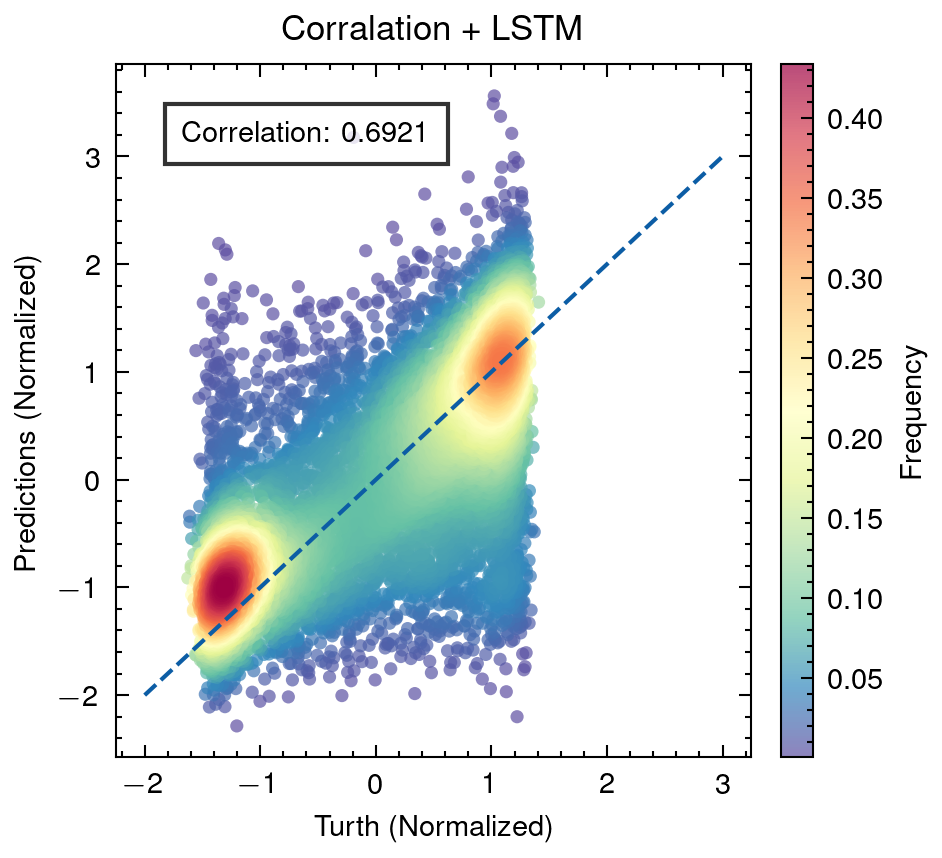

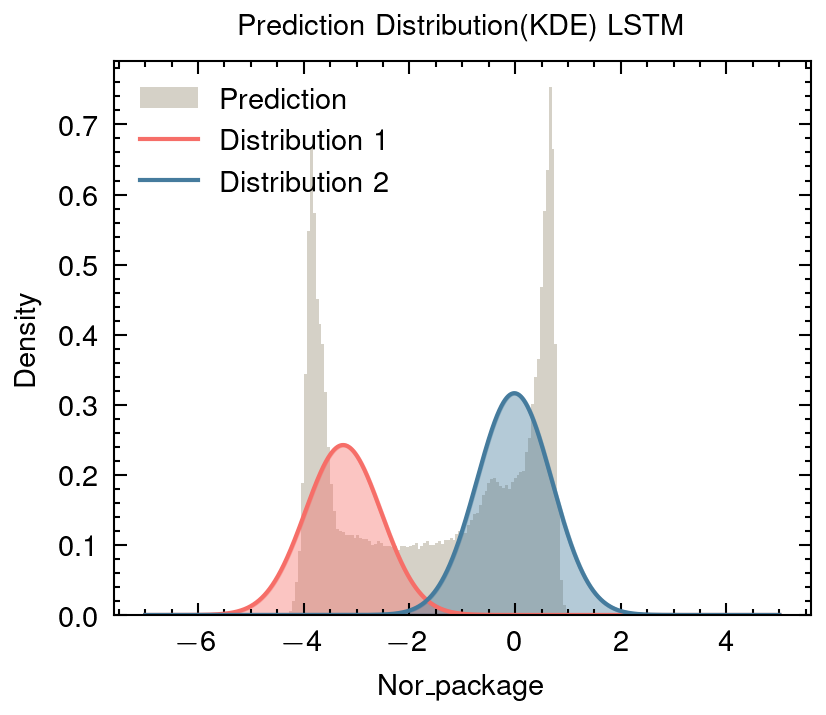

In [ ]:

df1 = pd.DataFrame(predicted_activity)
df2 = pd.DataFrame(y_test)

random_indices = np.random.choice(len(df1), size=10000, replace=False)
df1_sampled = df1.iloc[random_indices]
df2_sampled = df2.iloc[random_indices]

# 对数据进行归一化
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
xy = np.vstack([x_scaled, y_scaled])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x_scaled, y_scaled, z = x_scaled[idx], y_scaled[idx], z[idx]
plt.style.use('nature')
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
scatter = ax.scatter(x_scaled, y_scaled, marker='o', c=z, edgecolors='none', s=10, cmap='Spectral_r', alpha=0.7)

ax.set_xlabel('Turth (Normalized)')
ax.set_ylabel('Predictions (Normalized)')
ax.set_title('Correlation +  LSTM')

correlation = df1.corrwith(df2)
print("LR结果相关性：", correlation)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(scatter, cax=cax, label='Frequency')
ax.text(0.3, 0.9, f'Correlation: {correlation.values[0]:.4f}', transform=ax.transAxes, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))
ax.plot([-2, 3], [-2, 3], ls="--", )

plt.show()


plt.style.use('nature')
data = np.array(df1) 
data = data.reshape(-1, 1)  # 将数据转换成列向量的形式

# 使用GaussianMixture拟合数据
n_components = 2 # 设置混合模型的分量个数
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# 获取每个分量的均值和协方差矩阵
means = gmm.means_
covariances = gmm.covariances_

# 生成拟合后的分布
x = np.linspace(-7, 5, 100000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(3,2.4),dpi=300)
# 绘制原始数据和拟合后的分布
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')
#plt.plot(x, y, '-r', label='GMM fit')


# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
plt.title('Prediction Distribution(KDE)  LSTM',fontsize=7)
# ax.tick_params(axis='both', which='both', length=0)
# ax.set_yticks([])
plt.ylabel('Density')
plt.xlabel('Nor_package')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Reshape X_train to have a time dimension

X_train = np.array(aa_values_list)
y_train = np.array(nor_package_values_list)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Build the improved RNN model
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(128, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    tf.keras.layers.SimpleRNN(64, activation='relu', return_sequences=True),
    tf.keras.layers.SimpleRNN(32, activation='relu') ,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

model


Epoch 1/10
3123/3123 [==============================] - 117s 37ms/step - loss: 5.7629 - val_loss: 5.7800
Epoch 2/10
3123/3123 [==============================] - 116s 37ms/step - loss: 5.8152 - val_loss: 5.8914
Epoch 3/10
3123/3123 [==============================] - 116s 37ms/step - loss: 5.7165 - val_loss: 5.7243
Epoch 4/10
3123/3123 [==============================] - 118s 38ms/step - loss: 5.7340 - val_loss: 5.7133
Epoch 5/10
3123/3123 [==============================] - 117s 37ms/step - loss: 5.7430 - val_loss: 5.8420
Epoch 6/10
3123/3123 [==============================] - 118s 38ms/step - loss: 5.7476 - val_loss: 5.7026
Epoch 7/10
3123/3123 [==============================] - 137s 44ms/step - loss: 5.6862 - val_loss: 5.7064
Epoch 8/10
3123/3123 [==============================] - 118s 38ms/step - loss: 5.7292 - val_loss: 5.8080
Epoch 9/10
3123/3123 [==============================] - 119s 38ms/step - loss: 5.7300 - val_loss: 5.8542
Epoch 10/10
3123/3123 [==============================] 

In [ ]:
# Make predictions on the test set
predicted_activity = model.predict(X_test_scaled).flatten()

# Evaluate the model
mse = mean_squared_error(y_test, predicted_activity)
r2 = r2_score(y_test, predicted_activity)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

976/976 [==============================] - 11s 11ms/step
Mean Squared Error: 5.6208716838983
R-squared: 0.03933913521545351


C:\Users\WENJIA\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\WENJIA\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


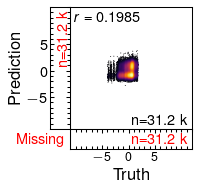

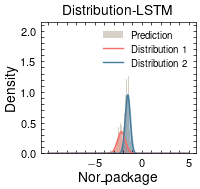

In [ ]:
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler

plt.style.use('nature')
x = pd.DataFrame(y_test) 
y = pd.DataFrame(predicted_activity)

remove = np.isnan(x) & np.isnan(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isnan(x)) & (~np.isnan(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isnan(x)]
x_missing = x[np.isnan(y)]

df1 = pd.DataFrame(predicted_activity)
df2 = pd.DataFrame(y_test)

random_indices = np.random.choice(len(df1), size=len(y), replace=False)

df1_sampled = df1.iloc[random_indices]
df2_sampled = df2.iloc[random_indices]

# 对数据进行归一化
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
xy = np.vstack([x_scaled, y_scaled])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x_both, y_both, c_both = x_scaled[idx], y_scaled[idx], z[idx]
fig = plt.figure(figsize=(1.4,1.3), dpi=150)
gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.4f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5])
ax.text(0.97, 0.97, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(0), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=8)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
# fig.savefig('../',dpi=300,bbox_inches='tight')


nor_package = df1
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 5, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# Plot the normal distribution for each component
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Distribution-LSTM',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-5, 0, 5]); 
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


# Reshape X_train to have a time dimension

X_train = np.array(aa_values_list)
y_train = np.array(nor_package_values_list)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Build the improved RNN model
model = tf.keras.Sequential([
    tf.keras.layers.GRU(128, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    tf.keras.layers.GRU(64, activation='relu', return_sequences=True),
    tf.keras.layers.GRU(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Make predictions on the test set
predicted_activity = model.predict(X_test_scaled).flatten()

# Evaluate the model
mse = mean_squared_error(y_test, predicted_activity)
r2 = r2_score(y_test, predicted_activity)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Epoch 1/10
18030/18030 [==============================] - 141s 8ms/step - loss: 5.2783 - val_loss: 4.9177
Epoch 2/10
18030/18030 [==============================] - 141s 8ms/step - loss: 3.7810 - val_loss: 3.8383
Epoch 3/10
18030/18030 [==============================] - 144s 8ms/step - loss: 3.3816 - val_loss: 3.2985
Epoch 4/10
18030/18030 [==============================] - 142s 8ms/step - loss: 3.3092 - val_loss: 3.2435
Epoch 5/10
18030/18030 [==============================] - 135s 7ms/step - loss: 3.2572 - val_loss: 3.2397
Epoch 6/10
18030/18030 [==============================] - 136s 8ms/step - loss: 3.1995 - val_loss: 3.1822
Epoch 7/10
18030/18030 [==============================] - 140s 8ms/step - loss: 3.1184 - val_loss: 3.1011
Epoch 8/10
18030/18030 [==============================] - 134s 7ms/step - loss: 3.0853 - val_loss: 3.0603
Epoch 9/10
18030/18030 [==============================] - 141s 8ms/step - loss: 3.0656 - val_loss: 3.0454
Epoch 10/10
5635/5635 [=======================

结果相关性： 0    0.707442
dtype: float64


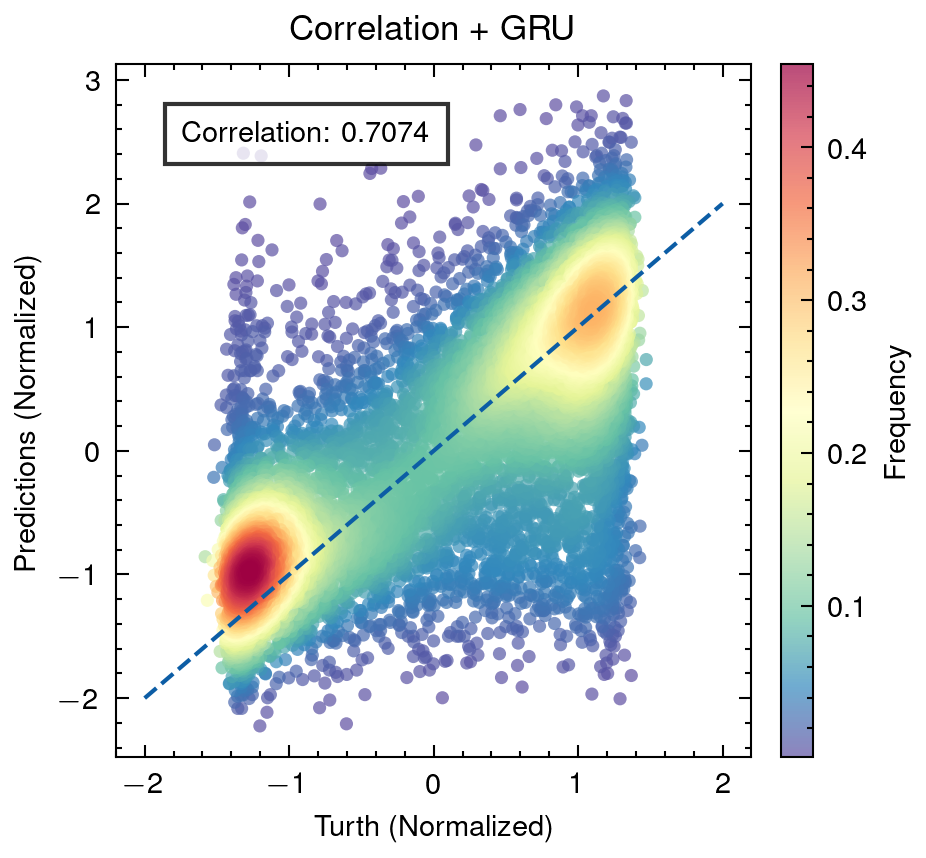

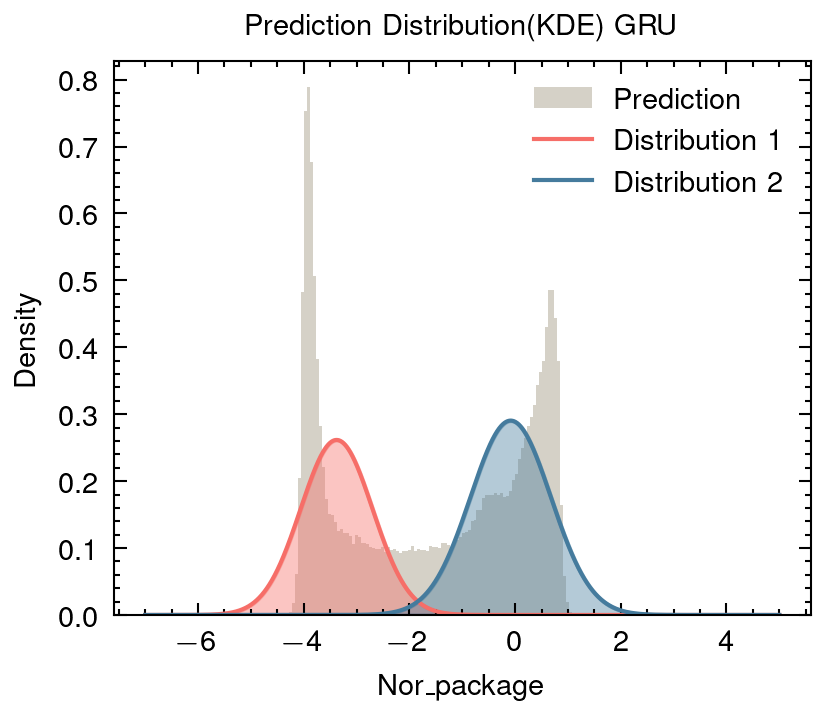

In [ ]:

df1 = pd.DataFrame(predicted_activity)
df2 = pd.DataFrame(y_test)

random_indices = np.random.choice(len(df1), size=10000, replace=False)
df1_sampled = df1.iloc[random_indices]
df2_sampled = df2.iloc[random_indices]

# 对数据进行归一化
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
xy = np.vstack([x_scaled, y_scaled])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x_scaled, y_scaled, z = x_scaled[idx], y_scaled[idx], z[idx]
plt.style.use('nature')
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
scatter = ax.scatter(x_scaled, y_scaled, marker='o', c=z, edgecolors='none', s=10, cmap='Spectral_r', alpha=0.7)

ax.set_xlabel('Turth (Normalized)')
ax.set_ylabel('Predictions (Normalized)')
ax.set_title('Correlation +  GRU')

correlation = df1.corrwith(df2)
print("结果相关性：", correlation)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(scatter, cax=cax, label='Frequency')
ax.text(0.3, 0.9, f'Correlation: {correlation.values[0]:.4f}', transform=ax.transAxes, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))
ax.plot([-2, 2], [-2, 2], ls="--", )

plt.show()


plt.style.use('nature')
data = np.array(df1) 
data = data.reshape(-1, 1)  # 将数据转换成列向量的形式

# 使用GaussianMixture拟合数据
n_components = 2 # 设置混合模型的分量个数
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# 获取每个分量的均值和协方差矩阵
means = gmm.means_
covariances = gmm.covariances_

# 生成拟合后的分布
x = np.linspace(-7, 5, 100000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(3,2.4),dpi=300)
# 绘制原始数据和拟合后的分布
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')
#plt.plot(x, y, '-r', label='GMM fit')


# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
plt.title('Prediction Distribution(KDE)   GRU',fontsize=7)
# ax.tick_params(axis='both', which='both', length=0)
# ax.set_yticks([])
plt.ylabel('Density')
plt.xlabel('Nor_package')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


# Reshape X_train to have a time dimension

X_train = np.array(aa_values_list)
y_train = np.array(nor_package_values_list)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Build the improved RNN model
model = tf.keras.Sequential([
    tf.keras.layers.GRU(128, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    tf.keras.layers.GRU(64, activation='relu', return_sequences=True),
    tf.keras.layers.GRU(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Make predictions on the test set
predicted_activity = model.predict(X_test_scaled).flatten()

# Evaluate the model
mse = mean_squared_error(y_test, predicted_activity)
r2 = r2_score(y_test, predicted_activity)

print("Mean Squared Error:", mse)
print("R-squared:", r2)




df1 = pd.DataFrame(predicted_activity)
df2 = pd.DataFrame(y_test)

random_indices = np.random.choice(len(df1), size=10000, replace=False)
df1_sampled = df1.iloc[random_indices]
df2_sampled = df2.iloc[random_indices]

# 对数据进行归一化
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
xy = np.vstack([x_scaled, y_scaled])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x_scaled, y_scaled, z = x_scaled[idx], y_scaled[idx], z[idx]
plt.style.use('nature')
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
scatter = ax.scatter(x_scaled, y_scaled, marker='o', c=z, edgecolors='none', s=10, cmap='Spectral_r', alpha=0.7)

ax.set_xlabel('Turth (Normalized)')
ax.set_ylabel('Predictions (Normalized)')
ax.set_title('Correlation +  GRU')

correlation = df1.corrwith(df2)
print("结果相关性：", correlation)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(scatter, cax=cax, label='Frequency')
ax.text(0.3, 0.9, f'Correlation: {correlation.values[0]:.4f}', transform=ax.transAxes, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))
ax.plot([-2, 2], [-2, 2], ls="--", )

plt.show()


plt.style.use('nature')
data = np.array(df1) 
data = data.reshape(-1, 1)  # 将数据转换成列向量的形式

# 使用GaussianMixture拟合数据
n_components = 2 # 设置混合模型的分量个数
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# 获取每个分量的均值和协方差矩阵
means = gmm.means_
covariances = gmm.covariances_

# 生成拟合后的分布
x = np.linspace(-7, 5, 100000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(3,2.4),dpi=300)
# 绘制原始数据和拟合后的分布
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')
#plt.plot(x, y, '-r', label='GMM fit')


# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
plt.title('Prediction Distribution(KDE)   GRU',fontsize=7)
# ax.tick_params(axis='both', which='both', length=0)
# ax.set_yticks([])
plt.ylabel('Density')
plt.xlabel('Nor_package')
plt.legend()
plt.show()

In [ ]:


df1 = pd.DataFrame(predicted_activity)
df2 = pd.DataFrame(y_test)

random_indices = np.random.choice(len(df1), size=10000, replace=False)
df1_sampled = df1.iloc[random_indices]
df2_sampled = df2.iloc[random_indices]

# 对数据进行归一化
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
xy = np.vstack([x_scaled, y_scaled])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x_scaled, y_scaled, z = x_scaled[idx], y_scaled[idx], z[idx]
plt.style.use('nature')
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
scatter = ax.scatter(x_scaled, y_scaled, marker='o', c=z, edgecolors='none', s=10, cmap='Spectral_r', alpha=0.7)

ax.set_xlabel('Turth (Normalized)')
ax.set_ylabel('Predictions (Normalized)')
ax.set_title('Correlation +  GRU')

correlation = df1.corrwith(df2)
print("结果相关性：", correlation)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(scatter, cax=cax, label='Frequency')
ax.text(0.3, 0.9, f'Correlation: {correlation.values[0]:.4f}', transform=ax.transAxes, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))
ax.plot([-2, 2], [-2, 2], ls="--", )

plt.show()


plt.style.use('nature')
data = np.array(df1) 
data = data.reshape(-1, 1)  # 将数据转换成列向量的形式

# 使用GaussianMixture拟合数据
n_components = 2 # 设置混合模型的分量个数
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# 获取每个分量的均值和协方差矩阵
means = gmm.means_
covariances = gmm.covariances_

# 生成拟合后的分布
x = np.linspace(-7, 5, 100000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(3,2.4),dpi=300)
# 绘制原始数据和拟合后的分布
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')
#plt.plot(x, y, '-r', label='GMM fit')


# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
plt.title('Prediction Distribution(KDE)   GRU',fontsize=7)
# ax.tick_params(axis='both', which='both', length=0)
# ax.set_yticks([])
plt.ylabel('Density')
plt.xlabel('Nor_package')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Reshape X_train to have a time dimension

X_train = np.array(aa_values_list)
y_train = np.array(nor_package_values_list)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Build the improved RNN model
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(128, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    tf.keras.layers.SimpleRNN(64, activation='relu', return_sequences=True),
    tf.keras.layers.SimpleRNN(32, activation='relu') ,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

model


Epoch 1/100
18030/18030 [==============================] - 60s 3ms/step - loss: 4.9956 - val_loss: 3.8308
Epoch 2/100
18030/18030 [==============================] - 62s 3ms/step - loss: 3.5600 - val_loss: 3.7664
Epoch 3/100
18030/18030 [==============================] - 62s 3ms/step - loss: 3.4052 - val_loss: 3.3349
Epoch 4/100
18030/18030 [==============================] - 62s 3ms/step - loss: 3.3481 - val_loss: 3.3510
Epoch 5/100
18030/18030 [==============================] - 64s 4ms/step - loss: 3.3163 - val_loss: 3.2960
Epoch 6/100
18030/18030 [==============================] - 62s 3ms/step - loss: 3.2945 - val_loss: 3.2824
Epoch 7/100
18030/18030 [==============================] - 66s 4ms/step - loss: 3.2798 - val_loss: 3.2531
Epoch 8/100
18030/18030 [==============================] - 67s 4ms/step - loss: 3.2657 - val_loss: 3.2583
Epoch 9/100
18030/18030 [==============================] - 66s 4ms/step - loss: 3.2538 - val_loss: 3.2454
Epoch 10/100
18030/18030 [====================

In [ ]:
# Make predictions on the test set
predicted_activity = model.predict(X_test_scaled).flatten()

# Evaluate the model
mse = mean_squared_error(y_test, predicted_activity)
r2 = r2_score(y_test, predicted_activity)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

5635/5635 [==============================] - 8s 1ms/step
Mean Squared Error: 3.035149836424904
R-squared: 0.5024089288776767


结果相关性： 0    0.708953
dtype: float64


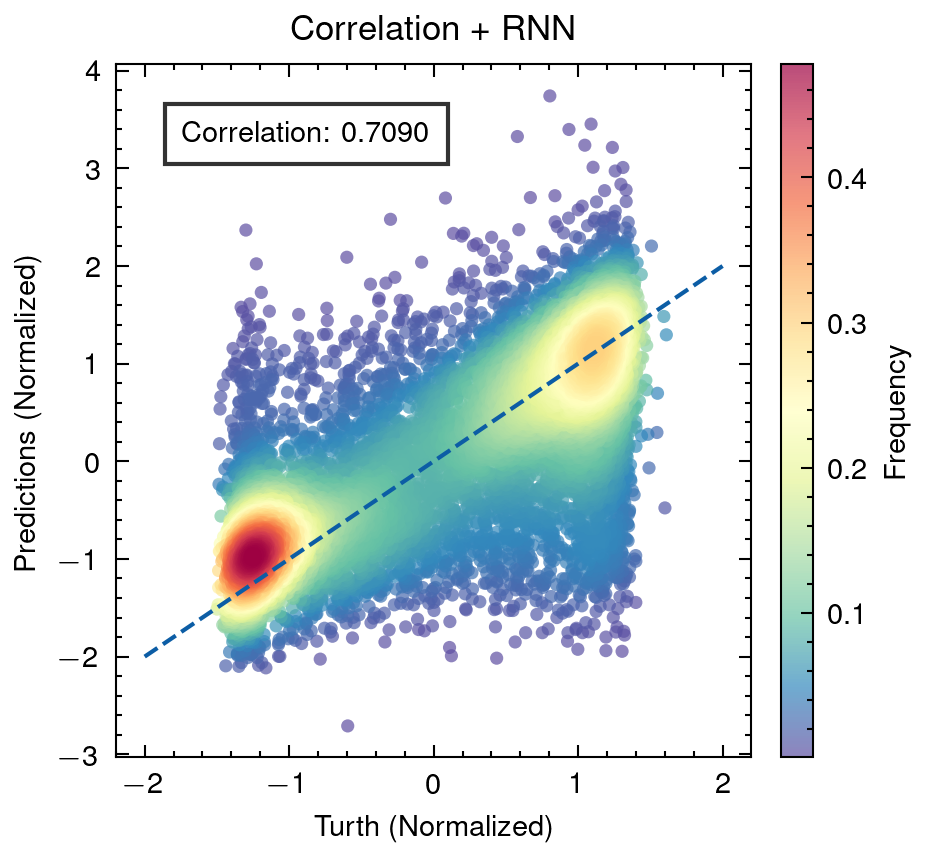

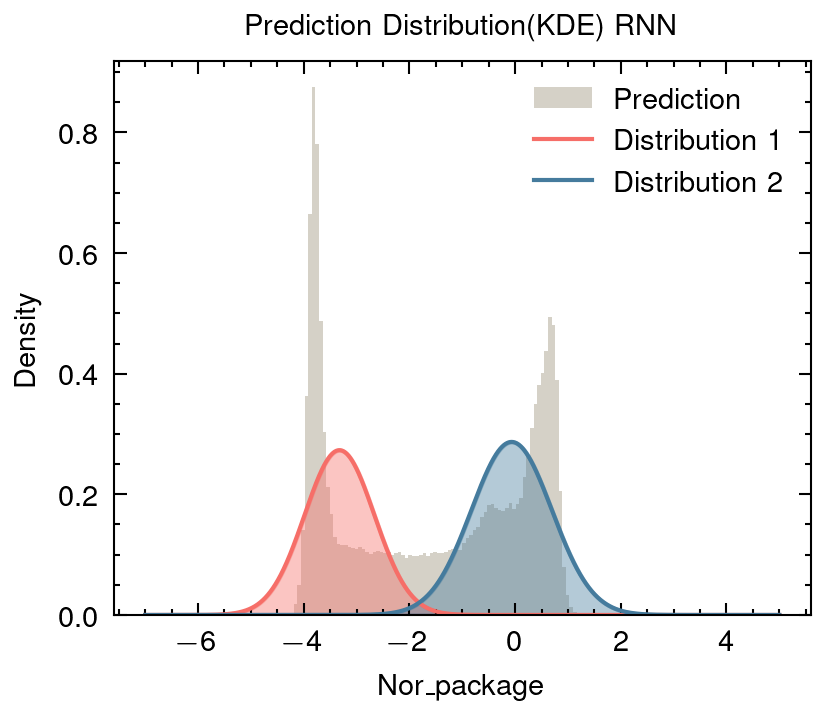

In [ ]:


df1 = pd.DataFrame(predicted_activity)
df2 = pd.DataFrame(y_test)

random_indices = np.random.choice(len(df1), size=10000, replace=False)
df1_sampled = df1.iloc[random_indices]
df2_sampled = df2.iloc[random_indices]

# 对数据进行归一化
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
xy = np.vstack([x_scaled, y_scaled])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x_scaled, y_scaled, z = x_scaled[idx], y_scaled[idx], z[idx]
plt.style.use('nature')
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
scatter = ax.scatter(x_scaled, y_scaled, marker='o', c=z, edgecolors='none', s=10, cmap='Spectral_r', alpha=0.7)

ax.set_xlabel('Turth (Normalized)')
ax.set_ylabel('Predictions (Normalized)')
ax.set_title('Correlation + RNN')

correlation = df1.corrwith(df2)
print("结果相关性：", correlation)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(scatter, cax=cax, label='Frequency')
ax.text(0.3, 0.9, f'Correlation: {correlation.values[0]:.4f}', transform=ax.transAxes, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))
ax.plot([-2, 2], [-2, 2], ls="--", )

plt.show()


plt.style.use('nature')
data = np.array(df1) 
data = data.reshape(-1, 1)  # 将数据转换成列向量的形式

# 使用GaussianMixture拟合数据
n_components = 2 # 设置混合模型的分量个数
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# 获取每个分量的均值和协方差矩阵
means = gmm.means_
covariances = gmm.covariances_

# 生成拟合后的分布
x = np.linspace(-7, 5, 100000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(3,2.4),dpi=300)
# 绘制原始数据和拟合后的分布
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')
#plt.plot(x, y, '-r', label='GMM fit')


# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
plt.title('Prediction Distribution(KDE)   RNN',fontsize=7)
# ax.tick_params(axis='both', which='both', length=0)
# ax.set_yticks([])
plt.ylabel('Density')
plt.xlabel('Nor_package')
plt.legend()
plt.show()

Epoch 1/20
18030/18030 [==============================] - 153s 8ms/step - loss: 5.2186 - val_loss: 4.7617
Epoch 2/20
18030/18030 [==============================] - 153s 8ms/step - loss: 4.1509 - val_loss: 3.6652
Epoch 3/20
18030/18030 [==============================] - 156s 9ms/step - loss: 3.3957 - val_loss: 3.3125
Epoch 4/20
18030/18030 [==============================] - 154s 9ms/step - loss: 3.3096 - val_loss: 3.3426
Epoch 5/20
18030/18030 [==============================] - 152s 8ms/step - loss: 3.2678 - val_loss: 3.2511
Epoch 6/20
18030/18030 [==============================] - 153s 8ms/step - loss: 3.2423 - val_loss: 3.2371
Epoch 7/20
18030/18030 [==============================] - 152s 8ms/step - loss: 3.2100 - val_loss: 3.1978
Epoch 8/20
18030/18030 [==============================] - 152s 8ms/step - loss: 3.1225 - val_loss: 3.0953
Epoch 9/20
18030/18030 [==============================] - 152s 8ms/step - loss: 3.0756 - val_loss: 3.0789
Epoch 10/20
18030/18030 [=====================

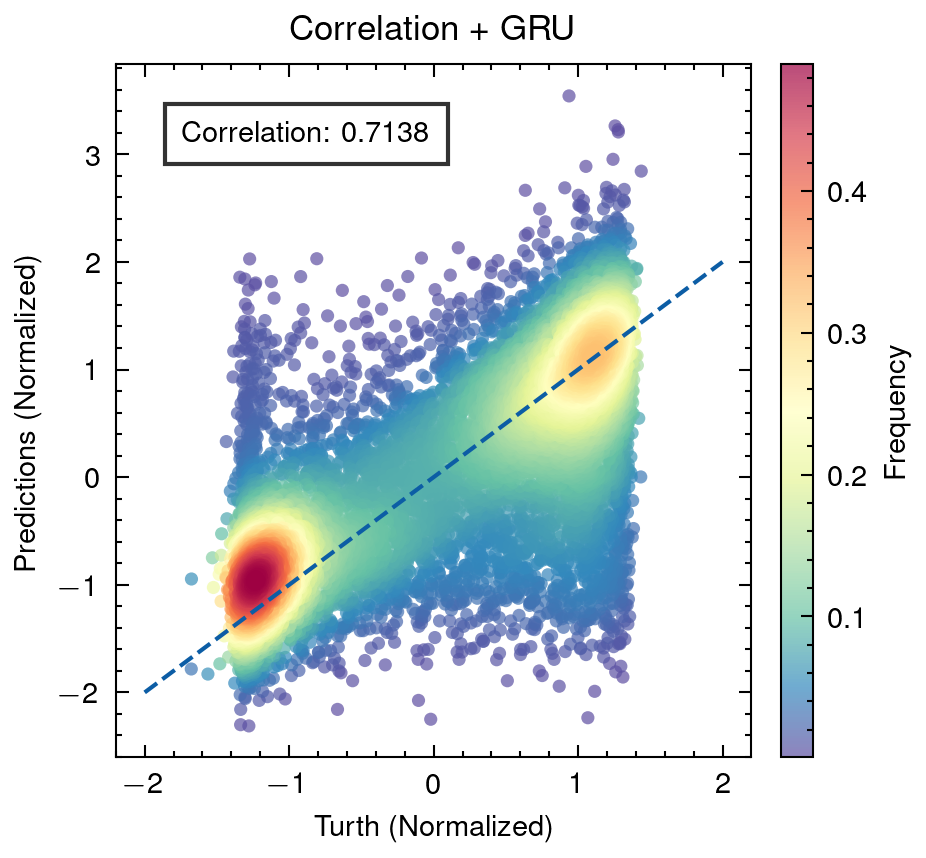

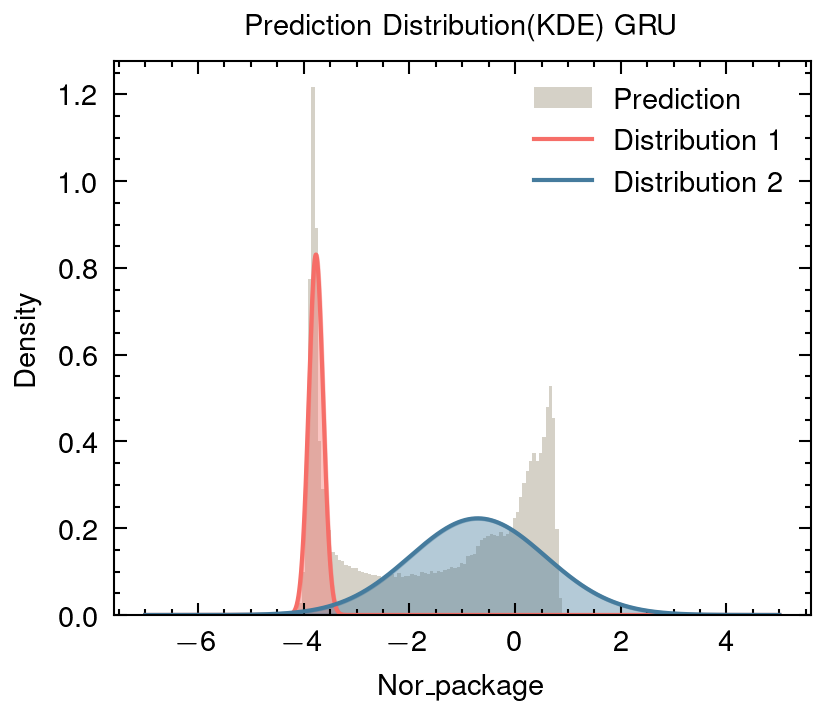

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


# Reshape X_train to have a time dimension

X_train = np.array(aa_values_list)
y_train = np.array(nor_package_values_list)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Build the improved RNN model
model = tf.keras.Sequential([
    tf.keras.layers.GRU(128, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    tf.keras.layers.GRU(64, activation='relu', return_sequences=True),
    tf.keras.layers.GRU(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Make predictions on the test set
predicted_activity = model.predict(X_test_scaled).flatten()

# Evaluate the model
mse = mean_squared_error(y_test, predicted_activity)
r2 = r2_score(y_test, predicted_activity)

print("Mean Squared Error:", mse)
print("R-squared:", r2)




df1 = pd.DataFrame(predicted_activity)
df2 = pd.DataFrame(y_test)

random_indices = np.random.choice(len(df1), size=10000, replace=False)
df1_sampled = df1.iloc[random_indices]
df2_sampled = df2.iloc[random_indices]

# 对数据进行归一化
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df1_sampled.values.reshape(-1, 1)).flatten()
y_scaled = scaler.fit_transform(df2_sampled.values.reshape(-1, 1)).flatten()
xy = np.vstack([x_scaled, y_scaled])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x_scaled, y_scaled, z = x_scaled[idx], y_scaled[idx], z[idx]
plt.style.use('nature')
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
scatter = ax.scatter(x_scaled, y_scaled, marker='o', c=z, edgecolors='none', s=10, cmap='Spectral_r', alpha=0.7)

ax.set_xlabel('Turth (Normalized)')
ax.set_ylabel('Predictions (Normalized)')
ax.set_title('Correlation +  GRU')

correlation = df1.corrwith(df2)
print("结果相关性：", correlation)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(scatter, cax=cax, label='Frequency')
ax.text(0.3, 0.9, f'Correlation: {correlation.values[0]:.4f}', transform=ax.transAxes, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))
ax.plot([-2, 2], [-2, 2], ls="--", )

plt.show()


plt.style.use('nature')
data = np.array(df1) 
data = data.reshape(-1, 1)  # 将数据转换成列向量的形式

# 使用GaussianMixture拟合数据
n_components = 2 # 设置混合模型的分量个数
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# 获取每个分量的均值和协方差矩阵
means = gmm.means_
covariances = gmm.covariances_

# 生成拟合后的分布
x = np.linspace(-7, 5, 100000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(3,2.4),dpi=300)
# 绘制原始数据和拟合后的分布
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')
#plt.plot(x, y, '-r', label='GMM fit')


# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
plt.title('Prediction Distribution(KDE)   GRU',fontsize=7)
# ax.tick_params(axis='both', which='both', length=0)
# ax.set_yticks([])
plt.ylabel('Density')
plt.xlabel('Nor_package')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

X_train = np.array(aa_values_list)
y_train = np.array(nor_package_values_list)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Define the Transformer model using TensorFlow
class TransformerModel(tf.keras.Model):
    def __init__(self, num_heads, d_model, ff_dim, dropout=0.5, name="transformer"):
        super(TransformerModel, self).__init__(name=name)

        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(d_model)]
        )
        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layer_norm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layer_norm2(out1 + ffn_output)

# Create the Transformer model
num_heads = 4  # Number of attention heads
d_model = 32  # Dimension of the model
ff_dim = 32  # Dimension of the feedforward layer
dropout = 0.1  # Dropout rate
sequence_length = X_train.shape[1]
num_features = X_train.shape[2]

inputs = tf.keras.Input(shape=(sequence_length, num_features))
transformer_block = TransformerModel(num_heads, d_model, ff_dim, dropout)
x = transformer_block(inputs)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
